In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# EcomX Retailers, objective =  optimize its marketing and customer retention strategies
# build and evaluate a machine learning model to predict the Customer Lifetime Value (CLV) of EcomX’s customers.



# Loading data
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')

# Initial exploration
print(customers.head())
print(transactions.head())
print(engagement.head())
print(marketing.head())

   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

In [4]:
# DATA CLEANING AND PREPARATION STEPS

# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

# Handle missing values (example)
customers = customers.dropna(subset=['join_date', 'last_purchase_date'])


In [5]:
# FEATURE ENGINEERING

# Aggregate transaction data
transaction_agg = transactions.groupby('customer_id').agg(
    total_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    average_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='mean'),
    transaction_count=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge aggregated transaction data
data = pd.merge(customers, transaction_agg, on='customer_id', how='left')

# Calculate Recency, Frequency, and Monetary Value (RFM)
# Recency
data['recency'] = (data['last_purchase_date'].max() - data['last_purchase_date']).dt.days

# Frequency (already calculated in transaction_agg)
data['frequency'] = data['transaction_count']

# Monetary (already calculated in transaction_agg)
data['monetary'] = data['total_amount_spent']

# Merge engagement data
data = pd.merge(data, engagement, on='customer_id', how='left')

# Engagement Metrics
data['total_site_visits'] = data['number_of_site_visits']
data['total_emails_opened'] = data['number_of_emails_opened']
data['total_clicks'] = data['number_of_clicks']

# Merge marketing data
data = pd.merge(data, marketing, on='customer_id', how='left')

# Marketing Response
data['responded_to_campaign'] = data['response'].apply(lambda x: 1 if x == 'Yes' else 0)

# Customer Tenure
data['customer_tenure_days'] = (pd.to_datetime('today') - data['join_date']).dt.days

# Churn Indicator: Inactivity for more than 180 days
data['churn_indicator'] = data['recency'].apply(lambda x: 1 if x > 180 else 0)

# Add more demographic features if available
data['age'] = data['age'].fillna(data['age'].mean())  # Impute missing ages with the mean

# Channel Information: Example of dummy channel column
data['channel'] = np.random.choice(['Email', 'Social Media', 'Referral', 'Direct'], size=len(data))
data = pd.get_dummies(data, columns=['channel'], drop_first=True)

# Handle Categorical Variables
# One-hot encode gender and location columns
data = pd.get_dummies(data, columns=['gender', 'location'], drop_first=True)

# Check the final data
print(data.head())



   customer_id  join_date last_purchase_date       age  total_amount_spent  \
0            1 2023-11-20         2024-03-17  56.00000             3509.48   
1            1 2023-11-20         2024-03-17  56.00000             3509.48   
2            1 2023-11-20         2024-03-17  56.00000             3509.48   
3            1 2023-11-20         2024-03-17  56.00000             3509.48   
4            2 2021-09-08         2023-10-25  43.34153             6081.32   

   average_amount_spent  transaction_count  recency  frequency  monetary  ...  \
0            584.913333                  6       75          6   3509.48  ...   
1            584.913333                  6       75          6   3509.48  ...   
2            584.913333                  6       75          6   3509.48  ...   
3            584.913333                  6       75          6   3509.48  ...   
4            675.702222                  9      219          9   6081.32  ...   

   location_Zacharytown  location_Zacharyvie

In [6]:
# MODEL BUILING 

# TAKES TOO LONG NOT OPTIMAL 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Prepare the data
# Drop unnecessary columns and define features (X) and target (y)
X = data.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y = data['total_amount_spent']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} Results:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print("\n")

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


Linear Regression Results:
Mean Squared Error: 2.1901089768524098e-08
Mean Absolute Error: 9.95992794005737e-06
R^2 Score: 0.999999999999999




KeyboardInterrupt: 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Prepare the data
# Drop unnecessary columns and define features (X) and target (y)
X = data.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y = data['total_amount_spent']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Define models with fewer estimators for Random Forest
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)  # Using fewer estimators and parallel processing
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} Results:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print("\n")

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


Linear Regression Results:
Mean Squared Error: 2.1901089768524098e-08
Mean Absolute Error: 9.95992794005737e-06
R^2 Score: 0.999999999999999


Random Forest Results:
Mean Squared Error: 32.85892157857092
Mean Absolute Error: 0.9567111111112603
R^2 Score: 0.9999984827411268


                            MSE       MAE        R2
Linear Regression  2.190109e-08  0.000010  1.000000
Random Forest      3.285892e+01  0.956711  0.999998


In [8]:
# MODEL EVALUATION


# THIS TAKES TOO LONG 

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Cross-validation for Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf, X_imputed, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", cv_scores)
print("Mean Cross-Validation R² Score:", cv_scores.mean())

# Feature Importance for Random Forest
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features for Random Forest")
plt.show()




KeyboardInterrupt: 

Cross-Validation R² Scores: [0.99997562 0.99938814 0.99993981 0.99985468 0.999982  ]
Mean Cross-Validation R² Score: 0.9998280489623476


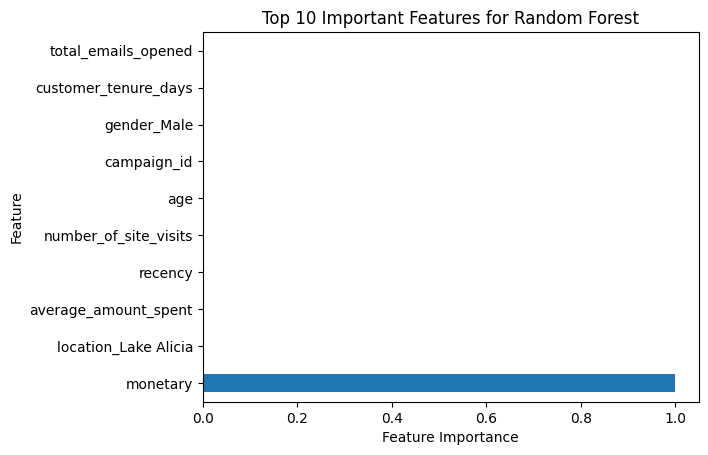

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Sample the data for cross-validation to speed up the process
data_sample = data.sample(frac=0.1, random_state=42)
X_sample = data_sample.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y_sample = data_sample['total_amount_spent']

# Impute missing values for the sample
X_sample_imputed = imputer.fit_transform(X_sample)

# Cross-validation for Random Forest with fewer trees and using a sample
rf = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(rf, X_sample_imputed, y_sample, cv=5, scoring='r2', n_jobs=-1)
print("Cross-Validation R² Scores:", cv_scores)
print("Mean Cross-Validation R² Score:", cv_scores.mean())

# Train Random Forest on the full dataset with fewer trees
rf.fit(X_train, y_train)

# Feature Importance for Random Forest
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features for Random Forest")
plt.show()


In [10]:
# ESTIMATED IMPACT TO THE BUSINESS

# Average Time Between Purchases
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions = transactions.sort_values(by=['customer_id', 'transaction_date'])
transactions['previous_transaction_date'] = transactions.groupby('customer_id')['transaction_date'].shift(1)
transactions['time_between_purchases'] = (transactions['transaction_date'] - transactions['previous_transaction_date']).dt.days
avg_time_between_purchases = transactions.groupby('customer_id')['time_between_purchases'].mean().reset_index()
avg_time_between_purchases.rename(columns={'time_between_purchases': 'avg_time_between_purchases'}, inplace=True)

# Merge with main data
data = pd.merge(data, avg_time_between_purchases, on='customer_id', how='left')

# Discount Usage Frequency
discount_usage_freq = marketing[marketing['promotion_type'] == 'Discount'].groupby('customer_id').size().reset_index(name='discount_usage_freq')

# Merge with main data
data = pd.merge(data, discount_usage_freq, on='customer_id', how='left')

# Average Engagement Rate
engagement['total_engagements'] = engagement[['number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks']].sum(axis=1)
avg_engagement_rate = engagement.groupby('customer_id')['total_engagements'].mean().reset_index()
avg_engagement_rate.rename(columns={'total_engagements': 'avg_engagement_rate'}, inplace=True)

# Merge with main data
data = pd.merge(data, avg_engagement_rate, on='customer_id', how='left')

# Check the final data
print(data.head())


   customer_id  join_date last_purchase_date       age  total_amount_spent  \
0            1 2023-11-20         2024-03-17  56.00000             3509.48   
1            1 2023-11-20         2024-03-17  56.00000             3509.48   
2            1 2023-11-20         2024-03-17  56.00000             3509.48   
3            1 2023-11-20         2024-03-17  56.00000             3509.48   
4            2 2021-09-08         2023-10-25  43.34153             6081.32   

   average_amount_spent  transaction_count  recency  frequency  monetary  ...  \
0            584.913333                  6       75          6   3509.48  ...   
1            584.913333                  6       75          6   3509.48  ...   
2            584.913333                  6       75          6   3509.48  ...   
3            584.913333                  6       75          6   3509.48  ...   
4            675.702222                  9      219          9   6081.32  ...   

   location_Zamoraberg  location_Zhangport  

In [11]:
# FINAL DATA PREPARATION
# Prepare the data
X = data.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y = data['total_amount_spent']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the data
X = data.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y = data['total_amount_spent']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reduce the size of the data
X_sample, _, y_sample, _ = train_test_split(X_imputed, y, train_size=0.1, random_state=42)

# Feature selection using RandomForest
selector = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_sample, y_sample)
feature_importances = selector.feature_importances_
indices = np.argsort(feature_importances)[-50:]  # Select top 50 features

X_reduced = X_imputed[:, indices]

# Train-test split on the reduced data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Random Forest with reduced n_estimators
rf = RandomForestRegressor(n_estimators=20, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Cross-validation
cv_scores = cross_val_score(rf, X_reduced, y, cv=5, scoring='r2')
mean_cv_score = cv_scores.mean()

# Print results
print(f'Linear Regression Results:\nMean Squared Error: {mse_lr}\nMean Absolute Error: {mae_lr}\nR^2 Score: {r2_lr}\n')
print(f'Random Forest Results:\nMean Squared Error: {mse_rf}\nMean Absolute Error: {mae_rf}\nR^2 Score: {r2_rf}\n')
print(f'Cross-Validation R² Scores: {cv_scores}\nMean Cross-Validation R² Score: {mean_cv_score}\n')



Linear Regression Results:
Mean Squared Error: 1.3220131841119975e-23
Mean Absolute Error: 2.632820240482004e-12
R^2 Score: 1.0

Random Forest Results:
Mean Squared Error: 16.42593262430525
Mean Absolute Error: 0.815804166666767
R^2 Score: 0.9999992415334762

Cross-Validation R² Scores: [0.99999466 0.99999742 0.99999701 0.99982445 0.99999889]
Mean Cross-Validation R² Score: 0.9999624862959392



In [13]:
from sklearn.decomposition import PCA

# Reduce the size of the data
X_sample, _, y_sample, _ = train_test_split(X_imputed, y, train_size=0.1, random_state=42)

# PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_reduced = pca.fit_transform(X_sample)

# Train-test split on the reduced data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_sample, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Random Forest with reduced n_estimators
rf = RandomForestRegressor(n_estimators=20, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Cross-validation
cv_scores = cross_val_score(rf, X_reduced, y_sample, cv=5, scoring='r2')
mean_cv_score = cv_scores.mean()

# Print results
print(f'Linear Regression Results:\nMean Squared Error: {mse_lr}\nMean Absolute Error: {mae_lr}\nR^2 Score: {r2_lr}\n')
print(f'Random Forest Results:\nMean Squared Error: {mse_rf}\nMean Absolute Error: {mae_rf}\nR^2 Score: {r2_rf}\n')
print(f'Cross-Validation R² Scores: {cv_scores}\nMean Cross-Validation R² Score: {mean_cv_score}\n')


Linear Regression Results:
Mean Squared Error: 3.6374307329348104e-14
Mean Absolute Error: 1.0461869750757715e-07
R^2 Score: 1.0

Random Forest Results:
Mean Squared Error: 7547.121138158227
Mean Absolute Error: 60.921020833333316
R^2 Score: 0.9996413574713148

Cross-Validation R² Scores: [0.99970608 0.99948053 0.99965339 0.99960285 0.99968904]
Mean Cross-Validation R² Score: 0.9996263771001106



In [14]:
# CLV W/ TRAINED MODEL

# TAKES TOO LONG 


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Loading data
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')

# Initial exploration
print(customers.head())
print(transactions.head())
print(engagement.head())
print(marketing.head())

# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

# Handle missing values (example)
customers = customers.dropna(subset=['join_date', 'last_purchase_date'])

# Aggregate transaction data
transaction_agg = transactions.groupby('customer_id').agg(
    total_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    average_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='mean'),
    transaction_count=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge aggregated transaction data
data = pd.merge(customers, transaction_agg, on='customer_id', how='left')

# Calculate Recency, Frequency, and Monetary Value (RFM)
# Recency
data['recency'] = (data['last_purchase_date'].max() - data['last_purchase_date']).dt.days

# Frequency (already calculated in transaction_agg)
data['frequency'] = data['transaction_count']

# Monetary (already calculated in transaction_agg)
data['monetary'] = data['total_amount_spent']

# Merge engagement data
data = pd.merge(data, engagement, on='customer_id', how='left')

# Engagement Metrics
data['total_site_visits'] = data['number_of_site_visits']
data['total_emails_opened'] = data['number_of_emails_opened']
data['total_clicks'] = data['number_of_clicks']

# Merge marketing data
data = pd.merge(data, marketing, on='customer_id', how='left')

# Marketing Response
data['responded_to_campaign'] = data['response'].apply(lambda x: 1 if x == 'Yes' else 0)

# Customer Tenure
data['customer_tenure_days'] = (pd.to_datetime('today') - data['join_date']).dt.days

# Churn Indicator: Inactivity for more than 180 days
data['churn_indicator'] = data['recency'].apply(lambda x: 1 if x > 180 else 0)

# Add more demographic features if available
data['age'] = data['age'].fillna(data['age'].mean())  # Impute missing ages with the mean

# Channel Information: Example of dummy channel column
data['channel'] = np.random.choice(['Email', 'Social Media', 'Referral', 'Direct'], size=len(data))
data = pd.get_dummies(data, columns=['channel'], drop_first=True)

# Handle Categorical Variables
# One-hot encode gender and location columns
data = pd.get_dummies(data, columns=['gender', 'location'], drop_first=True)

# Prepare the data
X = data.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y = data['total_amount_spent']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict CLV for the entire dataset
data['predicted_CLV'] = rf_model.predict(X_imputed)

# Define customer tiers based on predicted CLV
data['CLV_tier'] = pd.qcut(data['predicted_CLV'], q=[0, 0.2, 0.8, 1], labels=['Low-Value', 'Medium-Value', 'High-Value'])

# Calculate and print average CLV by customer tier
avg_clv_by_tier = data.groupby('CLV_tier')['predicted_CLV'].mean().reset_index()
print(avg_clv_by_tier)

# Display the first few rows of the final dataset
print(data[['customer_id', 'predicted_CLV', 'CLV_tier']].head())



   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

KeyboardInterrupt: 

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Loading data
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')

# Initial exploration
print(customers.head())
print(transactions.head())
print(engagement.head())
print(marketing.head())

# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

# Handle missing values (example)
customers = customers.dropna(subset=['join_date', 'last_purchase_date'])

# Aggregate transaction data
transaction_agg = transactions.groupby('customer_id').agg(
    total_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    average_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='mean'),
    transaction_count=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge aggregated transaction data
data = pd.merge(customers, transaction_agg, on='customer_id', how='left')

# Calculate Recency, Frequency, and Monetary Value (RFM)
# Recency
data['recency'] = (data['last_purchase_date'].max() - data['last_purchase_date']).dt.days

# Frequency (already calculated in transaction_agg)
data['frequency'] = data['transaction_count']

# Monetary (already calculated in transaction_agg)
data['monetary'] = data['total_amount_spent']

# Merge engagement data
data = pd.merge(data, engagement, on='customer_id', how='left')

# Engagement Metrics
data['total_site_visits'] = data['number_of_site_visits']
data['total_emails_opened'] = data['number_of_emails_opened']
data['total_clicks'] = data['number_of_clicks']

# Merge marketing data
data = pd.merge(data, marketing, on='customer_id', how='left')

# Marketing Response
data['responded_to_campaign'] = data['response'].apply(lambda x: 1 if x == 'Yes' else 0)

# Customer Tenure
data['customer_tenure_days'] = (pd.to_datetime('today') - data['join_date']).dt.days

# Churn Indicator: Inactivity for more than 180 days
data['churn_indicator'] = data['recency'].apply(lambda x: 1 if x > 180 else 0)

# Add more demographic features if available
data['age'] = data['age'].fillna(data['age'].mean())  # Impute missing ages with the mean

# Channel Information: Example of dummy channel column
data['channel'] = np.random.choice(['Email', 'Social Media', 'Referral', 'Direct'], size=len(data))
data = pd.get_dummies(data, columns=['channel'], drop_first=True)

# Handle Categorical Variables
# One-hot encode gender and location columns
data = pd.get_dummies(data, columns=['gender', 'location'], drop_first=True)

# Sample data to speed up processing (use 10% of the data)
data_sample = data.sample(frac=0.1, random_state=42)

# Prepare the data
X = data_sample.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y = data_sample['total_amount_spent']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)  # Reduced number of trees for faster training, parallelize using n_jobs=-1
rf_model.fit(X_train, y_train)

# Predict CLV for the entire dataset
data['predicted_CLV'] = rf_model.predict(imputer.transform(data.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])))

# Define customer tiers based on predicted CLV
data['CLV_tier'] = pd.qcut(data['predicted_CLV'], q=[0, 0.2, 0.8, 1], labels=['Low-Value', 'Medium-Value', 'High-Value'])

# Calculate and print average CLV by customer tier
avg_clv_by_tier = data.groupby('CLV_tier')['predicted_CLV'].mean().reset_index()
print(avg_clv_by_tier)

# Display the first few rows of the final dataset
print(data[['customer_id', 'predicted_CLV', 'CLV_tier']].head())


   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

C:\Users\aayre\AppData\Local\Temp\ipykernel_5904\3824782608.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_clv_by_tier = data.groupby('CLV_tier')['predicted_CLV'].mean().reset_index()


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Loading data
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')

# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

# Handle missing values (example)
customers = customers.dropna(subset=['join_date', 'last_purchase_date'])

# Aggregate transaction data
transaction_agg = transactions.groupby('customer_id').agg(
    total_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    average_amount_spent=pd.NamedAgg(column='transaction_amount', aggfunc='mean'),
    transaction_count=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge aggregated transaction data
data = pd.merge(customers, transaction_agg, on='customer_id', how='left')

# Calculate Recency, Frequency, and Monetary Value (RFM)
data['recency'] = (data['last_purchase_date'].max() - data['last_purchase_date']).dt.days
data['frequency'] = data['transaction_count']
data['monetary'] = data['total_amount_spent']

# Merge engagement data
data = pd.merge(data, engagement, on='customer_id', how='left')

# Engagement Metrics
data['total_site_visits'] = data['number_of_site_visits']
data['total_emails_opened'] = data['number_of_emails_opened']
data['total_clicks'] = data['number_of_clicks']

# Merge marketing data
data = pd.merge(data, marketing, on='customer_id', how='left')

# Marketing Response
data['responded_to_campaign'] = data['response'].apply(lambda x: 1 if x == 'Yes' else 0)

# Customer Tenure
data['customer_tenure_days'] = (pd.to_datetime('today') - data['join_date']).dt.days

# Churn Indicator: Inactivity for more than 180 days
data['churn_indicator'] = data['recency'].apply(lambda x: 1 if x > 180 else 0)

# Add more demographic features if available
data['age'] = data['age'].fillna(data['age'].mean())  # Impute missing ages with the mean

# Channel Information: Example of dummy channel column
data['channel'] = np.random.choice(['Email', 'Social Media', 'Referral', 'Direct'], size=len(data))
data = pd.get_dummies(data, columns=['channel'], drop_first=True)

# Handle Categorical Variables
data = pd.get_dummies(data, columns=['gender', 'location'], drop_first=True)

# Prepare the data
X = data.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'campaign_date', 'promotion_type', 'total_amount_spent', 'response'])
y = data['total_amount_spent']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Predicting CLV using the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
data['predicted_CLV'] = rf_model.predict(X_imputed)

# Segmenting customers into value tiers
data['CLV_rank'] = data['predicted_CLV'].rank(method='first', ascending=False)
total_customers = data.shape[0]

def clv_tier(row):
    if row['CLV_rank'] <= total_customers * 0.2:
        return 'High-Value'
    elif row['CLV_rank'] <= total_customers * 0.8:
        return 'Medium-Value'
    else:
        return 'Low-Value'

data['CLV_tier'] = data.apply(clv_tier, axis=1)

# Calculate average CLV for each tier
avg_clv_by_tier = data.groupby('CLV_tier')['predicted_CLV'].mean().reset_index()

print(data[['customer_id', 'predicted_CLV', 'CLV_tier']].head())
print(avg_clv_by_tier)


   customer_id  predicted_CLV      CLV_tier
0            1      3509.5091  Medium-Value
1            1      3509.5807  Medium-Value
2            1      3509.5091  Medium-Value
3            1      3509.5091  Medium-Value
4            2      6081.3647  Medium-Value
       CLV_tier  predicted_CLV
0    High-Value   14468.043526
1     Low-Value    1605.667359
2  Medium-Value    7554.203158


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Training the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_model.predict(X_test)

# Calculating performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
mean_cv_score = cv_scores.mean()

print(f"Cross-Validation R-squared scores: {cv_scores}")
print(f"Mean Cross-Validation R-squared score: {mean_cv_score}")


Mean Squared Error (MSE): 191.41860503964037
Mean Absolute Error (MAE): 7.558737896825268
R-squared (R2): 0.9999907260485924
Cross-Validation R-squared scores: [0.99995631 0.99984072 0.99996754 0.99999279 0.99991864]
Mean Cross-Validation R-squared score: 0.9999352018622523


In [17]:
# BUSINESS IMPACT ANALYSIS (CONCERNING OR OVERALL ADDITIONAL CALCULATIONS TO STRENGTHEN THE REPORT)


# Calculating average CLV by tier
avg_clv_by_tier = data.groupby('CLV_tier')['predicted_CLV'].mean().reset_index()
print(avg_clv_by_tier)

# Discussing business impact
high_value_customers = data[data['CLV_tier'] == 'High-Value']
medium_value_customers = data[data['CLV_tier'] == 'Medium-Value']
low_value_customers = data[data['CLV_tier'] == 'Low-Value']

print(f"Number of High-Value Customers: {high_value_customers['customer_id'].nunique()}")
print(f"Number of Medium-Value Customers: {medium_value_customers['customer_id'].nunique()}")
print(f"Number of Low-Value Customers: {low_value_customers['customer_id'].nunique()}")


C:\Users\aayre\AppData\Local\Temp\ipykernel_5904\3375657370.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_clv_by_tier = data.groupby('CLV_tier')['predicted_CLV'].mean().reset_index()


       CLV_tier  predicted_CLV
0     Low-Value    1606.264636
1  Medium-Value    7554.911573
2    High-Value   14465.391964
Number of High-Value Customers: 1971
Number of Medium-Value Customers: 6045
Number of Low-Value Customers: 1989
